In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from pathlib import Path
import PIL
import PIL.Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
! pip install PyDrive2

In [ ]:
_URL = 'https://drive.google.com/uc?export=download&id=1dfLQNvXPEo029WLsppazJ0hYDwmaR0iL'
path_to_zip = tf.keras.utils.get_file(origin=_URL, extract=True)

IMG_WIDTH=320
IMG_HEIGHT=243
BATCH_SIZE = 32

1254375/1254375 [==============================] - 0s 0us/step


In [ ]:
data_dir = Path('/root/.keras/datasets/face recognition imgs')
images = list(data_dir.glob('*'))
images

[PosixPath('/root/.keras/datasets/face recognition imgs/subject01.glasses.jpg'),
 PosixPath('/root/.keras/datasets/face recognition imgs/subject02.sad.png'),
 PosixPath('/root/.keras/datasets/face recognition imgs/subject02.noglasses.jpg'),
 PosixPath('/root/.keras/datasets/face recognition imgs/subject01.noglasses.jpg'),
 PosixPath('/root/.keras/datasets/face recognition imgs/subject01.sad.jpg'),
 PosixPath('/root/.keras/datasets/face recognition imgs/subject02.happy.jpg'),
 PosixPath('/root/.keras/datasets/face recognition imgs/subject01.happy.jpg'),
 PosixPath('/root/.keras/datasets/face recognition imgs/subject02.cry.jpg'),
 PosixPath('/root/.keras/datasets/face recognition imgs/subject01.cry.jpg'),
 PosixPath('/root/.keras/datasets/face recognition imgs/subject02.glasses.jpg')]

In [ ]:
len(images)

10

In [ ]:
str(images[8])

'/root/.keras/datasets/face recognition imgs/subject01.cry.jpg'

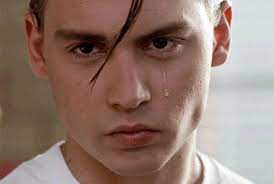

In [ ]:
PIL.Image.open(str(images[8]))

In [ ]:
# get face case
def get_situation(img_path):
  if img_path.is_file() and img_path.suffix != '':
    img_path = str(img_path)
    return os.path.split(img_path)[1].split(".")[1].replace("subject", "")
  else:
    return None

In [ ]:
get_situation(images[8])

'cry'

In [ ]:
# get person_id
def get_label_from_image_path(img_path):
  if img_path.is_file() and img_path.suffix != '':
    label = get_situation(img_path)
    person_id = os.path.split(img_path)[1].split(".")[0].replace("subject", "")
    return int(person_id)
  else:
    return None

In [ ]:
get_label_from_image_path(images[0])

1

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
# preprocess the data to be ready to trainig.
# fill your code

person_ids = []
images_as_trainable_objects = []
for image_path in images:
  person_id = get_label_from_image_path(image_path)
  if person_id:
    # adjust the label id to start from zero so that to adapt when converting to 
    # labels
    person_id = person_id - 1
    # 
    # prepare the image as the CNN needs
    image = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    image = img_to_array(image)
    image = image.reshape((IMG_WIDTH, IMG_HEIGHT, 3))
    image = preprocess_input(image)
    images_as_trainable_objects.append(image)
    person_ids.append(person_id)

In [ ]:
type(images_as_trainable_objects)

list

In [ ]:
len(images_as_trainable_objects)

10

In [ ]:
type(images_as_trainable_objects[0])

numpy.ndarray

In [ ]:
person_ids[0]

0

In [ ]:
#(number_of_samples, image_width, image_height, num_of_channels)

In [ ]:
set(person_ids)

{0, 1}

In [ ]:
print('before : ', type(images_as_trainable_objects))
images_as_trainable_objects = np.array(images_as_trainable_objects)
images_as_trainable_objects.shape

before :  <class 'list'>


(10, 320, 243, 3)

In [ ]:
# normalized RGB values for the first image and the first pixel in that image
images_as_trainable_objects[0][0][0]

array([-74.939, -63.779, -64.68 ], dtype=float32)

In [ ]:
# convert values from numeric to category (one hot encoding)
from tensorflow.python.keras.utils import np_utils
person_ids = np_utils.to_categorical(person_ids, 15)

In [ ]:
person_ids[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

## get VGG16 for Transfer Learning

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten, Convolution2D
from tensorflow.keras.models import Model
from tensorflow.keras import Input


In [ ]:
# load base model VGG16
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_tensor=Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
                   pooling='max',
                   classes=15)

# disable training on conv and inner layers
for layer in base_model.layers:
  layer.trainable = False

# I cat get the output from any specific layer
x = base_model.get_layer('block5_pool').output
# Stacking a new simple convolutional network on top of it
x = Convolution2D(64, 3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(15, activation='softmax')(x)

vgg = Model(inputs=base_model.input, outputs=x)
vgg.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 243, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 320, 243, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 320, 243, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 160, 121, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 160, 121, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 160, 121, 128)     147584    
                                                              

In [ ]:
# compile the model
vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# fit the model with the data
# put your code , 
# what is training_data
# what is labels
vgg.fit(images_as_trainable_objects[:-2], person_ids[:-2], batch_size=BATCH_SIZE, epochs=10)

Epoch 1/10
1/1 [==============================] - 13s 13s/step - loss: 23.9086 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 116ms/step - loss: 1.8342e-05 - accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 95ms/step - loss: 5.2154e-07 - accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 99ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 70ms/step - loss: 0.0000e+00 - accu

In [ ]:
person_ids[-1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
images_as_trainable_objects[-1].shape

(320, 243, 3)

In [ ]:
images_as_trainable_objects.shape

(10, 320, 243, 3)

In [ ]:
images_as_trainable_objects[-1].reshape((1, *images_as_trainable_objects[-1].shape)).shape

(1, 320, 243, 3)

In [ ]:
# validation 
# put your code !!
batch_of_one_sample = images_as_trainable_objects[-1].reshape((1, *images_as_trainable_objects[-1].shape))
yhat = vgg.predict(batch_of_one_sample)

1/1 [==============================] - 1s 725ms/step


In [ ]:
yhat

array([[9.9355620e-01, 6.4437659e-03, 0.0000000e+00, 2.1595444e-33,
        0.0000000e+00, 3.0879292e-21, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
preds_class_prob = np.max(yhat, axis=-1) 
preds_class_prob

array([0.9935562], dtype=float32)

In [ ]:
predicted_class = np.argmax(yhat, axis=-1)
predicted_class

array([0])

In [ ]:
tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
).summary()

553467096/553467096 [==============================] - 24s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           